![LMS spectrum](287px-Cones_SMJ2_E.png)
Normalized responsivity spectra of human cone cells, S, M, and L types (SMJ data based on Stiles and Burch RGB color-matching, linear scale, weighted for equal energy (http://www.cvrl.org/database/text/cones/smj2.htm)
![XYZ-RGB Gamut](CIE1931xy_CIERGB.png)
Gamut of the CIE RGB primaries and location of primaries on the CIE 1931 xy chromaticity diagram.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
from grating import *
from ext_signal import *

In [2]:
def luminance(rgb, use_XYZ = False):
    if use_XYZ:
        return rgb[1]
    else:
        return np.matmul(sRGB2XYZ[1,:],rgb.reshape((3,1)))
        
def cone_isolating(l,m,s,n,lms_wp,rgb_wp,x = None, linear = False): # in 255 and LMS space
    fig = plt.figure('color', dpi = 100)
    ax = fig.add_subplot(111)
    l = np.reshape(l,(n,1))
    m = np.reshape(m,(n,1))
    s = np.reshape(s,(n,1))
    lms = np.concatenate([l,m,s],1)

    rgb = np.matmul(LMS2sRGB, lms.T)
    if not linear:
        rgb = apply_sRGB_gamma(rgb/255)*255
    #rgb = np.matmul(LMS2sRGB, lms.T)
    if x is None:
        x = np.linspace(0,255,n)
    
    onRecord = False
    recordOn = False
    offRecord = False
    x0 = 0
    x1 = 255
    for i in range(n):
        color = rgb[:,i].astype('float').T/255
        if (color>=0).all() and (color<=1).all():
            if not offRecord:
                x0 = x[i]
                Off = color
                lmsOff = np.array([l[i],m[i],s[i]]).T/255
                offRecord = True
            ax.plot(x[i], np.sum(luminance(color, False)*255),'.', c=color)
            onColor = color
            lmsOn = np.array([l[i],m[i],s[i]]).T/255
            x1 = x[i]
        else:
            if offRecord and not onRecord:
                recordOn = True
                onRecord = True
        
        if recordOn or i == n-1:
            On = onColor
            recordOn = False
    ax.plot(x,rgb[0,:],'r')
    ax.plot(x,rgb[1,:],'g')
    ax.plot(x,rgb[2,:],'b')
    #ax.plot(l[:-1],np.diff(rgb[2,:]),':b')
    #ax.plot(l[:-1],np.diff(rgb[1,:]),':g')
    ax.plot(np.zeros(255)+lms_wp,np.arange(255),':k')
    ax.plot(np.arange(n), np.zeros(n)+rgb_wp,':k')
    ax.plot(x,np.zeros(x.size),':k')
    ax.plot(x,np.zeros(x.size)+255,':k')
    ax.set_xlim([x0,x1])
    ax.set_ylim([0,255])
    if onRecord and offRecord:
        return On, Off, lmsOn, lmsOff
    else:
        raise Exception('no positive values')

white point in XYZ: [0.47521427 0.5        0.54445019]
white point in LMS: [0.47461831 0.51771038 0.54363796]
in LMS peak:[[0.64864865 0.51771038 0.54363796]], valley:[[0.3003003  0.51771038 0.54363796]]
in RGB peak:[0.99750679 0.46338886 0.49262777], valley:[0.00166056 0.53669166 0.50721641]
L:[[0.36708861 0.         0.        ]]
L:[0.36667431 0.         0.        ]


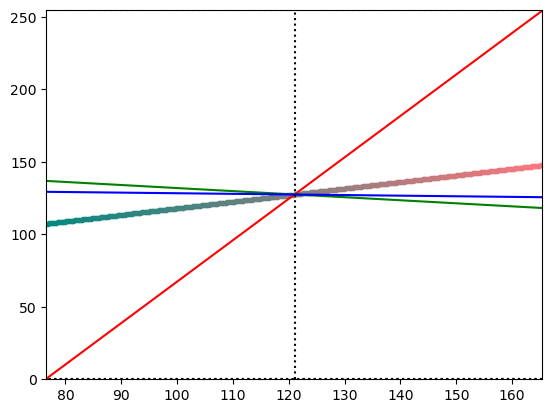

In [4]:
#cone-isolating
use_XYZ = True
#L_isolating = False # False as M-isolating
L_isolating = True
linear = True
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.5
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
print(f'white point in XYZ: {wp}')
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())
print(f'white point in LMS: {LMS_wp}')

lum = Y
n = 1000
if L_isolating:
    l = np.reshape(np.linspace(0,255,n),(n,1))
    m = np.zeros(n) + LMS_wp[1]*255
else:# M-isolating
    m = np.reshape(np.linspace(0,255,n),(n,1))
    l = np.zeros((n,1)) + LMS_wp[0]*255

s = np.zeros((n,1)) + LMS_wp[2]*255
if L_isolating:
    mid_p = LMS_wp[0]*255
else:
    mid_p = LMS_wp[1]*255
On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,mid_p,lum, x=np.linspace(0,255,n), linear = linear)
print(f'in LMS peak:{lms_On}, valley:{lms_Off}')
print(f'in RGB peak:{On}, valley:{Off}')
midpoint_con = np.abs(lms_On - lms_Off)/(lms_On + lms_Off)
wp_con = np.min(np.vstack((np.abs(lms_On - LMS_wp)/LMS_wp, np.abs(LMS_wp-lms_Off)/LMS_wp)),0)
print(f'L:{midpoint_con}')
print(f'L:{wp_con}')

white point in XYZ: [0.47521427 0.5        0.54445019]
white point in LMS: [0.47461831 0.51771038 0.54363796]
in LMS peak:[[0.47461831 0.82382382 0.54363796]], valley:[[0.47461831 0.21121121 0.54363796]]
in RGB peak:[0.00134622 0.85460814 0.46375611], valley:[0.99927186 0.14496502 0.53612159]
L:[[0.         0.59187621 0.        ]]
L:[0.         0.59128318 0.        ]


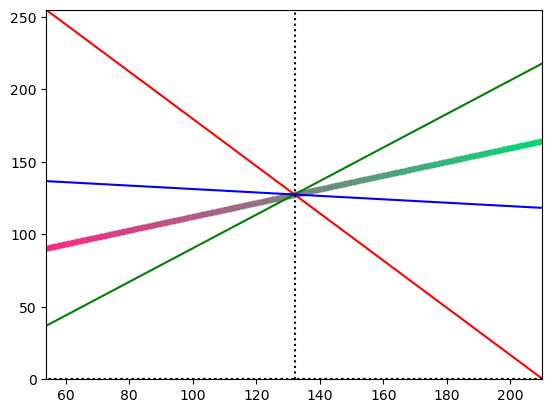

In [9]:
#cone-isolating
use_XYZ = True
#L_isolating = False # False as M-isolating
L_isolating = False
linear = True
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.5
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
print(f'white point in XYZ: {wp}')
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())
print(f'white point in LMS: {LMS_wp}')

lum = Y
n = 1000
if L_isolating:
    l = np.reshape(np.linspace(0,255,n),(n,1))
    m = np.zeros(n) + LMS_wp[1]*255
else:# M-isolating
    m = np.reshape(np.linspace(0,255,n),(n,1))
    l = np.zeros((n,1)) + LMS_wp[0]*255

s = np.zeros((n,1)) + LMS_wp[2]*255
if L_isolating:
    mid_p = LMS_wp[0]*255
else:
    mid_p = LMS_wp[1]*255
On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,mid_p,lum, x=np.linspace(0,255,n), linear = linear)
print(f'in LMS peak:{lms_On}, valley:{lms_Off}')
print(f'in RGB peak:{On}, valley:{Off}')
midpoint_con = np.abs(lms_On - lms_Off)/(lms_On + lms_Off)
wp_con = np.min(np.vstack((np.abs(lms_On - LMS_wp)/LMS_wp, np.abs(LMS_wp-lms_Off)/LMS_wp)),0)
print(f'L:{midpoint_con}')
print(f'L:{wp_con}')

[0.33199659 0.33200664 0.33194427]
n=788
rgb = (array([0.99909623, 0.20637164, 0.33263549]), array([0.00319369, 0.50410522, 0.31653956]))
lms = (array([[0.50650651, 0.27006487, 0.3609756 ]]), array([[0.28128128, 0.48617513, 0.3609756 ]]))
wp = [0.31514656 0.3437597  0.3609756 ], lum = 0.33996061920030635
[[0.39389389 0.37812    0.3609756 ]]
[0.28589581 0.2857694  0.        ]
[0.28589581 0.2857694  0.        ]


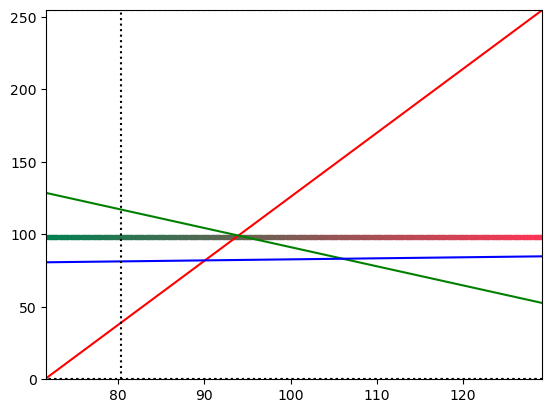

In [10]:
#equiluminant
from ext_signal import *
use_XYZ = False
linear = True
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.332
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)
print(f'{wp}')

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())

lum = Y

n = 1000
s = np.zeros((n,1)) + LMS_wp[2]*255
l = np.linspace(0,255,n).reshape(n,1)
m = (Y*255 - LMS2XYZ[1,0]*l + LMS2XYZ[1,2]*s)/LMS2XYZ[1,1]
pick = np.logical_and(m>=0, m<=255)
m = m[pick]
l = l[pick]
s = s[pick]
n = np.sum(pick)
assert(np.logical_and(l>=0,l<=255).all())
assert(np.logical_and(m>=0,m<=255).all())
assert(np.logical_and(s>=0,s<=255).all())
print(f'n={n}')
if use_XYZ:
    lum = wp[1]*255

On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,LMS_wp[0]*255,lum, x=l, linear = linear)

if use_XYZ:
    On = np.matmul(XYZ2sRGB, On)
    Off = np.matmul(XYZ2sRGB, Off)
    if not linear:
        On = apply_sRGB_gamma(On)
        Off = apply_sRGB_gamma(Off)
    print(f'rgb = {On, Off}')
else:
    print(f'rgb = {On, Off}')
print(f'lms = {lms_On, lms_Off}')

LMS_wp0 = np.sum(LMS_wp)/3
print(f'wp = {LMS_wp}, lum = {LMS_wp0}')
print((lms_On + lms_Off)/2)
#LMS_wp0 = LMS_wp
LMS_wp0 = (lms_On + lms_Off)/2
wp_con_min = np.min(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
wp_con_max = np.max(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
print(f'{wp_con_min}')
print(f'{wp_con_max}')